# Choice of MAST shots to load for scrapping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from functools import partial

import pathlib
import os
import psutil
import time
import json

## Selection of shot_index and variable_channels with no NaN

In [2]:
def to_dask(shot: int, group: str, level: int = 2) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Data level to retrieve (default is 2).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [3]:
def retry_to_dask(shot_id, group, retries=3, delay=1):
    """
    Retry loading a shot's data as a Dask Dataset with exponential backoff.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    retries: Number of retry attempts (default is 3).
    delay: Delay in seconds between retries (default is 5).

    Returns
    xr.Dataset
        The Dask Dataset for the specified shot and group.
    or Error
    """
    for attempt in range(retries):
        try:
            return to_dask(shot_id, group)
        except Exception as e:
            if attempt < retries - 1:
                print(f"Retrying connection to {shot_id} in group {group} (attempt {attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                raise e

In [4]:
def process_shot(shot_id, group, verbose=False):
    """
    Process a single shot, returning a dictionary of results.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    verbose: bool
        Displays messages for debugging or tracking.
    
    Returns
    shot_id: int
        The shot ID processed.
    shot_result: dict
        Dictionary containing the presence of variables and their channels:
    """
    shot_result = {}
    try:
        ds = retry_to_dask(shot_id, group)
        shot_vars = set(ds.data_vars)

        for var in shot_vars:
            da = ds[var]
            time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
            
            if not time_dims:
                if verbose:
                    print(f"Skipping {var} with no time dimension: {da.dims}")
                continue
            
            time_dim = time_dims[0]
            other_dims = [dim for dim in da.dims if dim != time_dim]

            # 1. Variable 1D
            if not other_dims:
                key = var
                try:
                    if np.issubdtype(da.dtype, np.floating):
                        has_valid = da.notnull().any().compute()
                        shot_result[key] = True if has_valid else None
                    else:
                        # For non-floating types, we assume presence if the variable exists.
                        shot_result[key] = True
                except Exception as e:
                    if verbose:
                        print(f"Error processing {var} in shot {shot_id}: {e}")
                    shot_result[key] = False

            # 2. Variable 2D
            else:
                for dim in other_dims:
                    if dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                        continue
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            channel_has_data = da.notnull().any(dim=time_dim)
                        else:
                            # For non-floating types, we assume presence if the variable exists.
                            channel_has_data = xr.ones_like(ds[dim], dtype=bool)
                        
                        channel_results = channel_has_data.compute()
                        
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            try:
                                chan_valid = channel_results.sel({dim: coord_val}).item()
                                shot_result[key] = True if chan_valid else None
                            except Exception as e:
                                if verbose:
                                    print(f"Error accessing {coord_val} in {var}: {e}")
                                shot_result[key] = False
                    
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            shot_result[key] = False

    except Exception as e:
        if verbose:
            print(f"Error processing shot {shot_id}: {e}")
        shot_result = {}

    return shot_id, shot_result



In [5]:
def get_optimal_workers(task_type="cpu"):
    """
    Get the optimal number of workers for parallel processing based on the task type.

    Parameters
    task_type: str
        Type of task to determine the optimal number of workers (possible: "cpu", or "gpu").

    Returns the optimal number of workers based on the task type.
    """
    cpu_logical = os.cpu_count()
    
    if task_type == "gpu":
        try:
            import torch
            if torch.cuda.is_available():
                return torch.cuda.device_count()
            else:
                return 0
        except ImportError:
            return 0
    elif task_type == "cpu":
        try:
            return psutil.cpu_count(logical=False)
        except:
            return max(1, cpu_logical // 2)  # Default to half of logical cores
    else:
        return max(1, cpu_logical - 1) # Default to one less than logical cores
    

In [6]:
def check_variable_presence_parallel(
    shots: list[int],
    group: str,
    verbose: bool = False,
    max_workers: int = None,
    task_type: str = "cpu"
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers(task_type=task_type)
    print(f"Use of {max_workers} workers (type: {task_type})")

    var_presence = {}
    seen_shots = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot, group=group, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_id, shot_result = future.result()
            seen_shots.append(shot_id)
            
            for key, present in shot_result.items():
                if key not in var_presence:
                    var_presence[key] = {s: False for s in seen_shots}
                var_presence[key][shot_id] = present
            
            # Mark missing variables/channels as False: case where there was a "continue" in process_shot.
            for key in var_presence:
                if shot_id not in var_presence[key]:
                    var_presence[key][shot_id] = False

    df = pd.DataFrame(var_presence).T
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df

In [7]:
URL = 'https://mastapp.site'
shots_disappearance = pd.read_parquet(f'{URL}/parquet/level2/shots')
sorted_disappearance = shots_disappearance.sort_values("timestamp")
shots = sorted_disappearance['shot_id'].tolist()
print("Number of shots: ", len(shots))

Number of shots:  11573


In [8]:
group = 'magnetics'
suffix = "mscred"

In [14]:
variable_presence_all = check_variable_presence_parallel(
    shots=shots, 
    group=group, 
    verbose=True,
    max_workers=None,
    task_type="gpu"
)

Use of 15 workers (type: gpu)


Checking variables (parallel): 100%|██████████| 11573/11573 [1:01:54<00:00,  3.12it/s]


In [10]:
file_path = f"notebooks/result_files/all_shots_{group}"
file_name = f"variable_presence_all_shots_{group}.csv"
path = pathlib.Path().absolute().parent.parent / file_path / file_name
print(path)
variable_presence_all.to_csv(path, index=True)

/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/notebooks/result_files/all_shots_magnetics/variable_presence_all_shots_magnetics.csv


NameError: name 'variable_presence_all' is not defined

#### Plot results

In [16]:
# Visualization of variable presence
from matplotlib.colors import ListedColormap


def plot_variable_presence(variable_presence_all: pd.DataFrame, plot: bool = True, register: bool = False, register_path: str = "foo.png") -> None:
    """
    Plot the presence of variables across all shots in a group.

    Parameters
    variable_presence_all: pd.DataFrame
        DataFrame with variable presence across shots.
    group: str
        Diagnostic group name (e.g., "magnetics").
    plot: bool
        If True, display the plot.
    register: bool
        If True, save the plot to a file.
    register_name: str
        Name of the file to save the plot (if register is True).

    Returns
    None    
    """
    
    # Create an integer matrix for colormapping: 0 = False, 1 = True
    plot_df = variable_presence_all.fillna(False).infer_objects(copy=False)
    plot_matrix = plot_df.to_numpy()
    int_matrix = plot_matrix.astype(int)

    # Dimensions
    n_vars, n_shots = int_matrix.shape

    # Colors: 0 = red, 1 = green
    cmap = ListedColormap(["#4caf50", "#f44336"])  # green for True, red for False

    # Plot
    fig, ax = plt.subplots(figsize=(n_shots * 0.01, max(16, n_vars * 0.25)))
    im = ax.imshow(~int_matrix, aspect='auto', cmap=cmap, interpolation='none')


    ax.set_yticks(np.arange(n_vars))
    ax.set_yticklabels(variable_presence_all.index)
    ax.set_xticks(np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int))
    ax.set_xticklabels([variable_presence_all.columns[i] for i in np.linspace(0, n_shots - 1, min(n_shots, 1000), dtype=int)], rotation=90)
    ax.set_xlabel("Shot ID")
    ax.set_ylabel("Variable::Channel")
    ax.set_title("Variable Presence Across Shots (green = present, red = missing)")
    ax.grid(False, axis='x')
    ax.set_yticks(np.arange(n_vars + 1) - 0.5, minor=True)
    ax.grid(True, axis='y', which='minor', color='gray', linestyle='--')

    if register:
        plt.savefig(register_path, dpi="figure")
        print(f"Plot saved to {register_path}")
    if plot:
        plt.show()
    return None

In [12]:
register_dir = pathlib.Path().absolute().parent.parent/ f"results/figures/mast_data"
plot_variable_presence(variable_presence_all, plot=True, register=True, register_path=register_dir / f"variable_presence_{group}.png")

NameError: name 'variable_presence_all' is not defined

## Selection of shots and variable channels in good health

In [13]:
def check_variable_presence_all(path: str, group: str = group, shot_threshold: float = 0.99, var_threshold: float = 0.8, register_path: str = "foo_filtered.png") -> list:
    """
    Select the good shots and variables::channels to avoid the presence of too many NaNs in the dataset.

    Parameters
    path: str
        Path to the CSV file containing variable presence data.

    Returns
    list(
        good_shots: list of shot IDs that are present in enough variables.
        bad_shots: list of shot IDs that are missing too many variables.
        good_vars: list of variable::channel names that are present in enough shots.
        bad_vars: list of variable::channel names that are missing too many shots.)
    """
    # Load the variable presence DataFrame
    path = pathlib.Path().absolute().parent.parent / path
    df = pd.read_csv(path, index_col=0)
    df = df.fillna(False).infer_objects(copy=False)

    # Then delete the variables::channels for which at least 50% of the content is True. And store them in an array.
    bad_vars = df.index[df.sum(axis=1) < (len(df.columns) * var_threshold)].tolist()
    df = df.drop(index=bad_vars)
    plot_variable_presence(df, plot=True, register=False)

    # First delete the shots for which all variables are False. And store them in an array.
    bad_shots = df.columns[df.sum(axis=0) < (len(df.index) * shot_threshold)].tolist()
    df = df.drop(columns=bad_shots)
    plot_variable_presence(df, plot=True, register=True, register_path=register_path)


    return [
        df.columns.tolist(),    # Good shots
        bad_shots,              # Bad shots
        df.index.tolist(),      # Good variables::channels
        bad_vars                # Bad variables::channels
        ]

/tmp/ipykernel_1516225/3182272273.py:18: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,

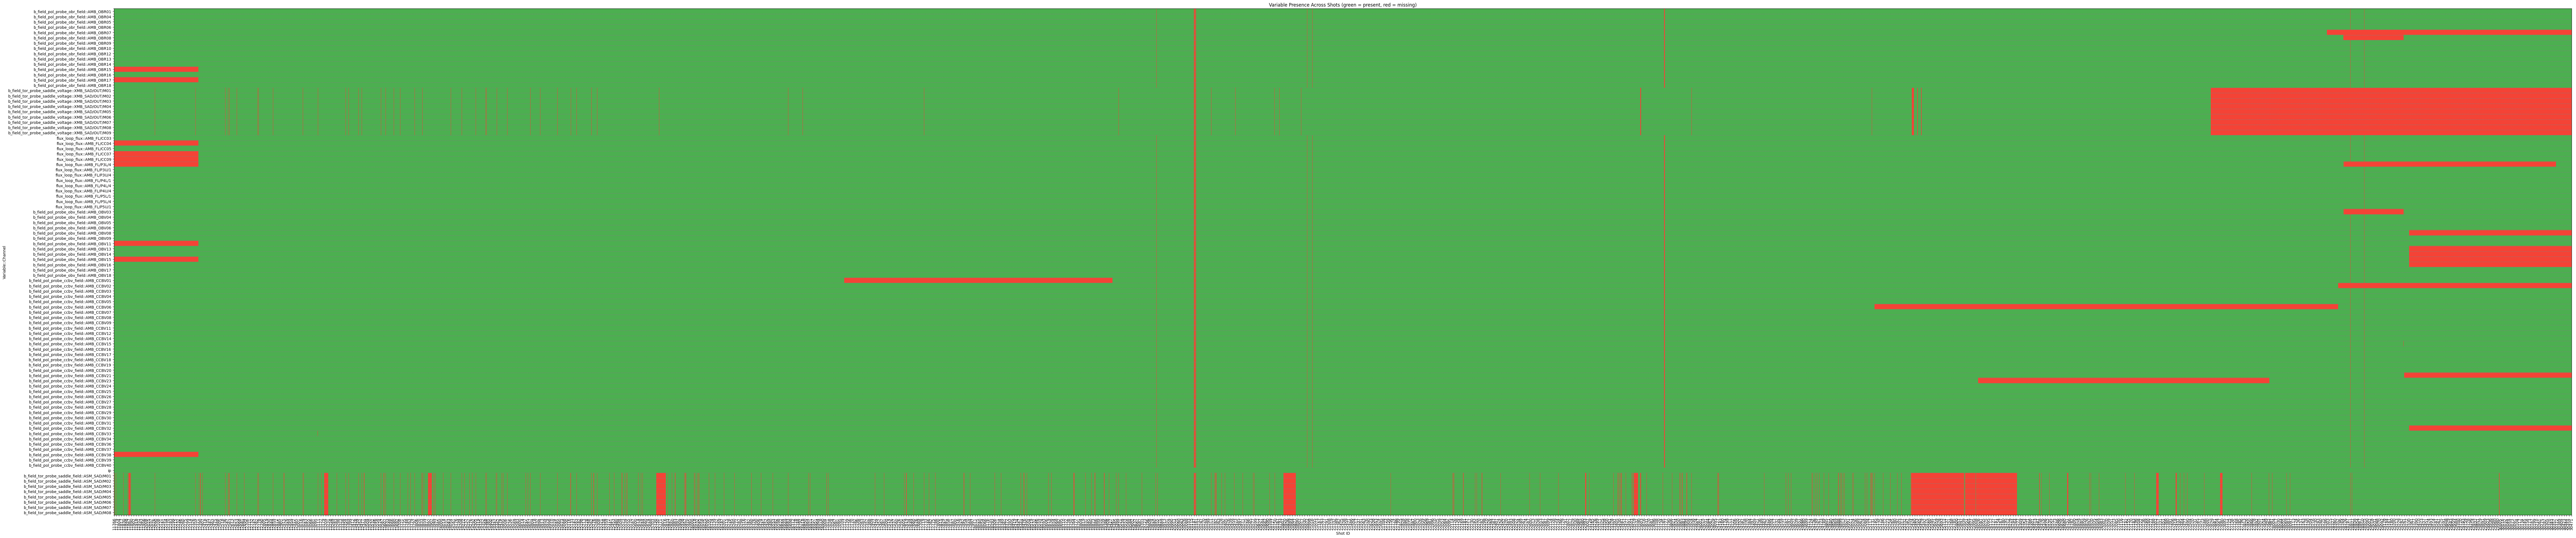

Plot saved to /home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/results/figures/mast_data/variable_presence_magnetics_filtered.png


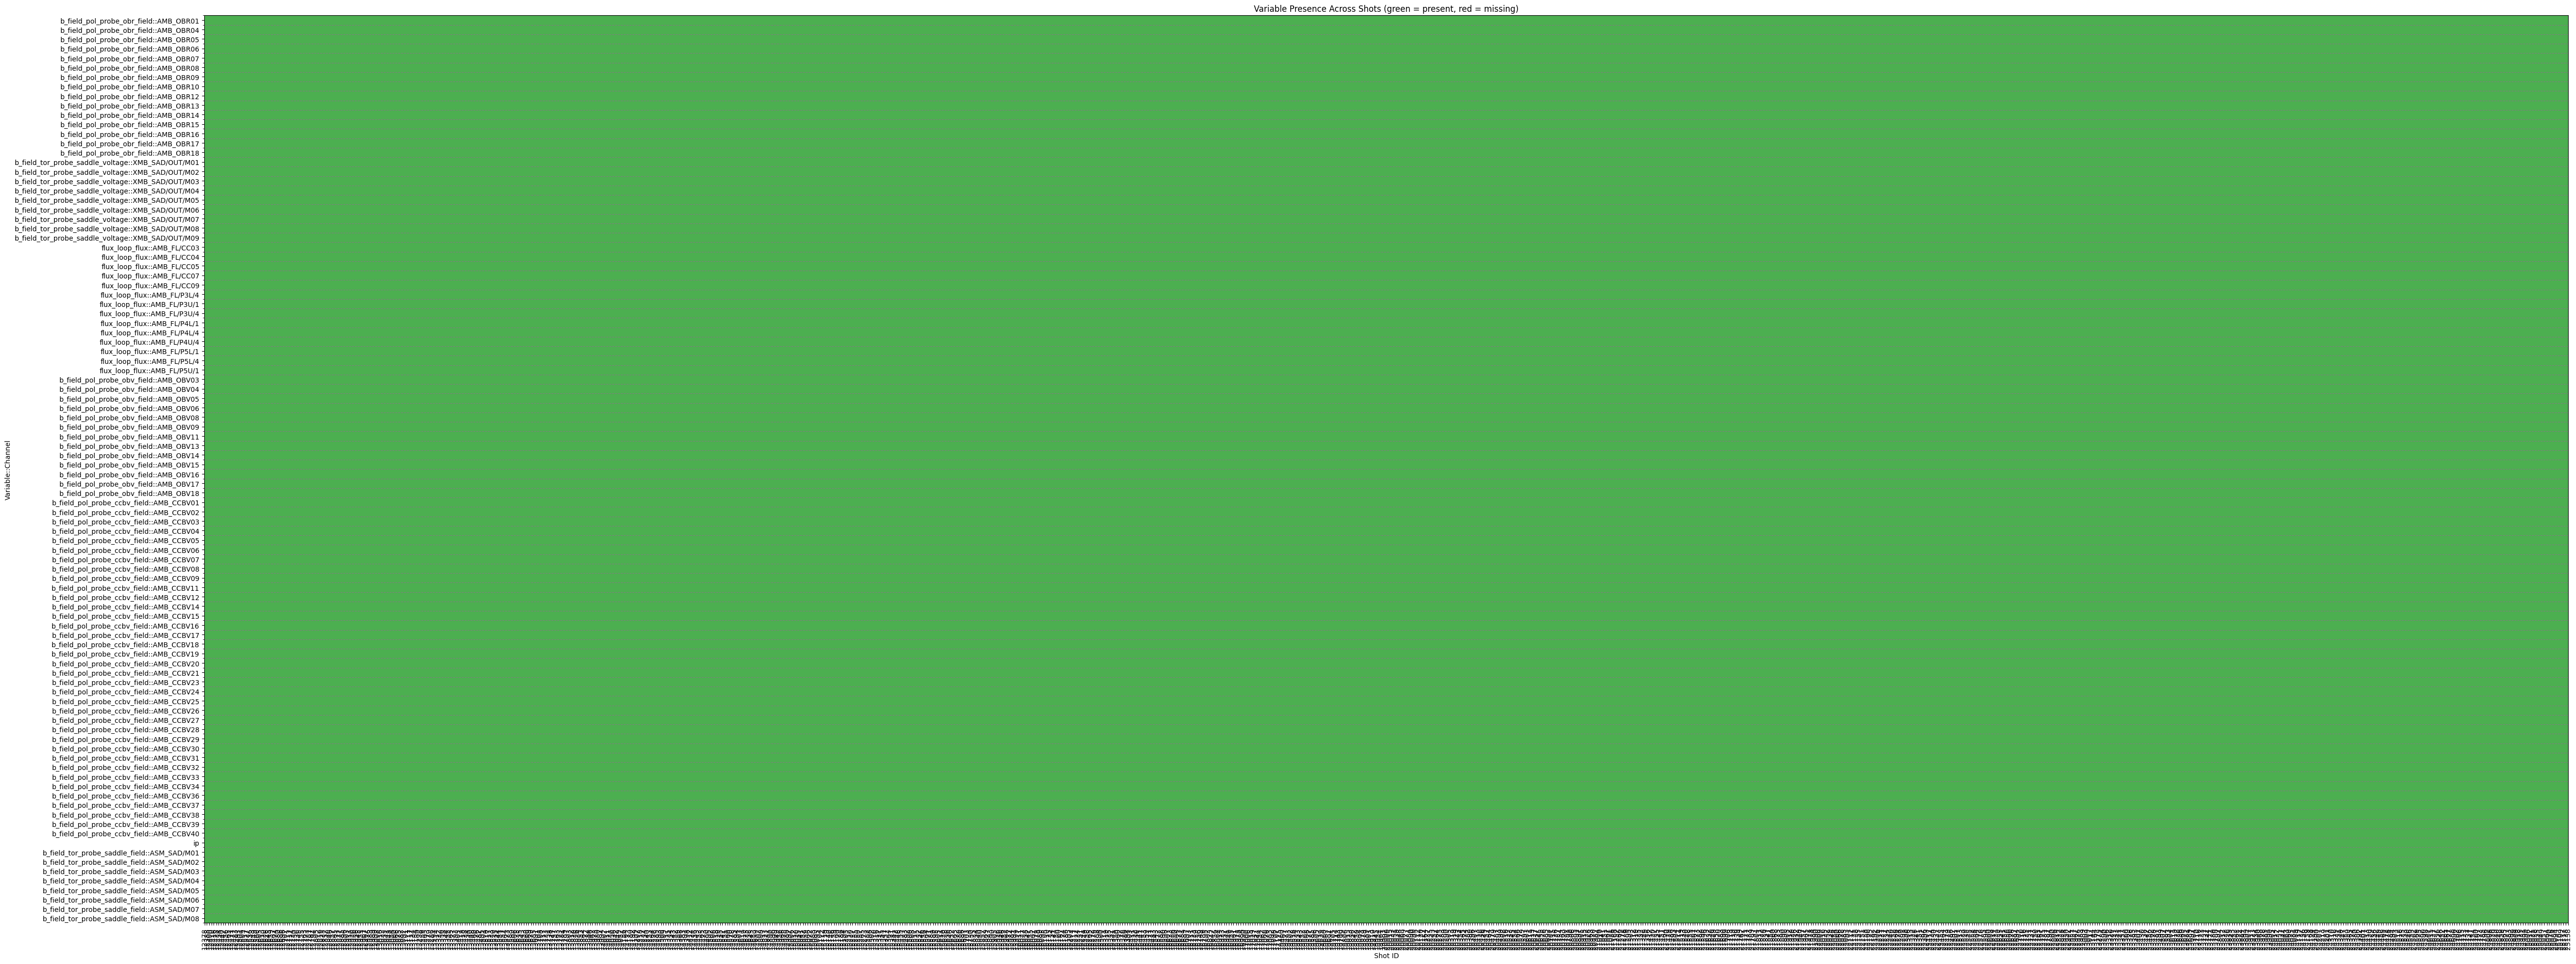

Number of bad variable::channel IDs: 58
Bad variable::channel IDs: ['b_field_pol_probe_obr_field::AMB_OBR02', 'b_field_pol_probe_obr_field::AMB_OBR03', 'b_field_pol_probe_obr_field::AMB_OBR11', 'b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M10', 'b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M11', 'b_field_tor_probe_saddle_voltage::XMB_SAD/OUT/M12', 'flux_loop_flux::AMB_FL/P6L/1', 'b_field_pol_probe_obv_field::AMB_OBV01', 'b_field_pol_probe_obv_field::AMB_OBV02', 'b_field_pol_probe_obv_field::AMB_OBV07', 'b_field_pol_probe_obv_field::AMB_OBV10', 'b_field_pol_probe_obv_field::AMB_OBV12', 'b_field_pol_probe_ccbv_field::AMB_CCBV10', 'b_field_pol_probe_ccbv_field::AMB_CCBV13', 'b_field_pol_probe_ccbv_field::AMB_CCBV22', 'b_field_pol_probe_ccbv_field::AMB_CCBV35', 'b_field_pol_probe_cc_field::XMC_CC/MV/201', 'b_field_pol_probe_cc_field::XMC_CC/MV/210', 'b_field_pol_probe_cc_field::XMC_CC/MV/220', 'b_field_pol_probe_cc_field::XMC_CC/MV/230', 'b_field_pol_probe_cc_field::XMC_CC/MV/240', 'b_f

In [14]:
good_shot_ids, bad_shot_ids, good_vars_ids, bad_vars_ids = check_variable_presence_all(
    path=f"notebooks/result_files/all_shots_{group}/variable_presence_all_shots_{group}.csv",
    group=group,
    shot_threshold=0.99,
    var_threshold=0.8,
    register_path=register_dir / f"variable_presence_{group}_filtered.png"
)

print(f"Number of bad variable::channel IDs: {len(bad_vars_ids)}")
print("Bad variable::channel IDs:", bad_vars_ids[:25])

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:25])


In [41]:
data = {
    "metadata": {
        "description": "We selected shots and variables based on Nan presence or not.",
        "good_shot_ids": "List of shot IDs with at least one float value",
        "bad_shot_ids": "List of shot IDs with no values at all or with all NaN values", 
        "good_vars_ids": "List of variable IDs recommended for analysis",
        "bad_vars_ids": "List of variable IDs to avoid or filter out"
    },
    "good_shot_ids": good_shot_ids,
    "bad_shot_ids": bad_shot_ids,
    "good_vars_ids": good_vars_ids,
    "bad_vars_ids": bad_vars_ids,
}

path = pathlib.Path().absolute().parent.parent / f"notebooks/result_files/all_shots_{group}"
file_name = path / f"result_lists_{group}.json"
with open(file_name, "w") as f:
    json.dump(data, f, indent=4)

## See the rate of NaN values in each channel to keep only those who have a small and sparse amount

In [9]:
def compute_nan_proportions_shot(shot_id, group, verbose=False):
    """
    Compute NaN proportions for all variables in a single shot.
    
    Parameters:
    shot_id : int
        Shot ID to retrieve data for.
    group : str
        Diagnostic group to retrieve data from.
    verbose : bool, optional
        Displays messages for debugging or tracking.
    
    Returns:
    tuple
        (shot_id, dict) where the dict contains NaN proportions for each variable/channel
    """
    nan_proportions = {}
    try:
        ds = retry_to_dask(shot_id, group)
        shot_vars = set(ds.data_vars)

        for var in shot_vars:
            da = ds[var]
            time_dims = [dim for dim in da.dims if 'time' in dim.lower()]
            
            if not time_dims:
                if verbose:
                    print(f"Skipping {var} with no time dimension: {da.dims}")
                continue
            
            time_dim = time_dims[0]
            other_dims = [dim for dim in da.dims if dim != time_dim]

            # 1D Variable (time only)
            if not other_dims:
                key = var
                try:
                    if np.issubdtype(da.dtype, np.floating):
                        # Calculate NaN proportion
                        nan_prop = da.isnull().mean().compute().item() * 100
                        nan_proportions[key] = nan_prop
                    else:
                        # For non-floating types, assume full of NaNs
                        nan_proportions[key] = 1.0
                except Exception as e:
                    if verbose:
                        print(f"Error processing {var} in shot {shot_id}: {e}")
                    nan_proportions[key] = np.nan

            # Multi-dimensional Variable (time + channels)
            else:
                for dim in other_dims:
                    if dim not in ds.coords:
                        if verbose:
                            print(f"Warning: {dim} not found for {var} in shot {shot_id}")
                        continue
                    
                    try:
                        if np.issubdtype(da.dtype, np.floating):
                            # Calculate NaN proportion for each channel
                            channel_nan_props = da.isnull().mean(dim=time_dim).compute() * 100
                        else:
                            # For non-floating types, assume full of NaNs
                            channel_nan_props = xr.ones_like(ds[dim], dtype=float)
                        
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            try:
                                nan_prop = channel_nan_props.sel({dim: coord_val}).item()
                                nan_proportions[key] = nan_prop
                            except Exception as e:
                                if verbose:
                                    print(f"Error accessing {coord_val} in {var}: {e}")
                                nan_proportions[key] = np.nan
                    
                    except Exception as e:
                        if verbose:
                            print(f"Error processing {var} in shot {shot_id}: {e}")
                        for coord_val in ds[dim].values:
                            key = f"{var}::{coord_val}"
                            nan_proportions[key] = np.nan

    except Exception as e:
        if verbose:
            print(f"Error processing shot {shot_id}: {e}")
        nan_proportions = {}

    return shot_id, nan_proportions

In [21]:
def compute_nan_proportions_parallel(shot_ids, group, max_workers=None, task_type="cpu", verbose=False):
    """
    Compute NaN proportions for multiple shots in parallel.
    
    Parameters:
    shot_ids : list
        List of shot IDs to process.
    group : str
        Diagnostic group to retrieve data from.
    max_workers : int, optional
        Maximum number of parallel workers. If None, uses all available CPUs.
    task_type : str, optional
        Type of task to optimize for (e.g., "cpu" or "gpu").
    verbose : bool, optional
        Displays messages for debugging or tracking.
    
    Returns:
    pd.DataFrame
        DataFrame with NaN proportions for each variable/channel across all shots
    """
    if max_workers is None:
        max_workers = get_optimal_workers(task_type=task_type)
    print(f"Use of {max_workers} workers (type: {task_type})")

    # Create partial function with fixed group and verbose parameters
    process_func = partial(compute_nan_proportions_shot, group=group, verbose=verbose)
    
    # Process shots in parallel
    results = {}
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_shot = {executor.submit(process_func, shot_id): shot_id for shot_id in shot_ids}
        
        # Process results as they complete
        for future in tqdm.tqdm(
            as_completed(future_to_shot),
            total=len(shot_ids),
            desc="Checking NaN rates (parallel)"
        ):
            shot_id = future_to_shot[future]
            try:
                shot_id, nan_props = future.result()
                results[shot_id] = nan_props
            except Exception as e:
                if verbose:
                    print(f"Error processing shot {shot_id}: {e}")
                results[shot_id] = {}
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.name = 'shot_id'
    
    # Sort columns and rows for consistency
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.sort_index()
    
    return df.T

In [22]:
path = pathlib.Path().absolute().parent.parent / f"notebooks/result_files/all_shots_{group}"
file_name = path / f"result_lists_{group}.json"
with open(file_name, "r") as f:
    good_shot_ids = json.load(f)["good_shot_ids"]

In [23]:
nan_proportion_per_shot = compute_nan_proportions_parallel(
    shot_ids=good_shot_ids[:30], 
    group="magnetics",
    max_workers=None,
    task_type="gpu",
    verbose=True
)

Use of 2 workers (type: gpu)


Checking NaN rates (parallel): 100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


In [24]:
file_path = f"notebooks/result_files/nan_stats_{group}"
path = pathlib.Path().absolute().parent.parent / file_path / f"nan_stats_by_shot_{suffix}.csv"
nan_proportion_per_shot.to_csv(path, index=True)

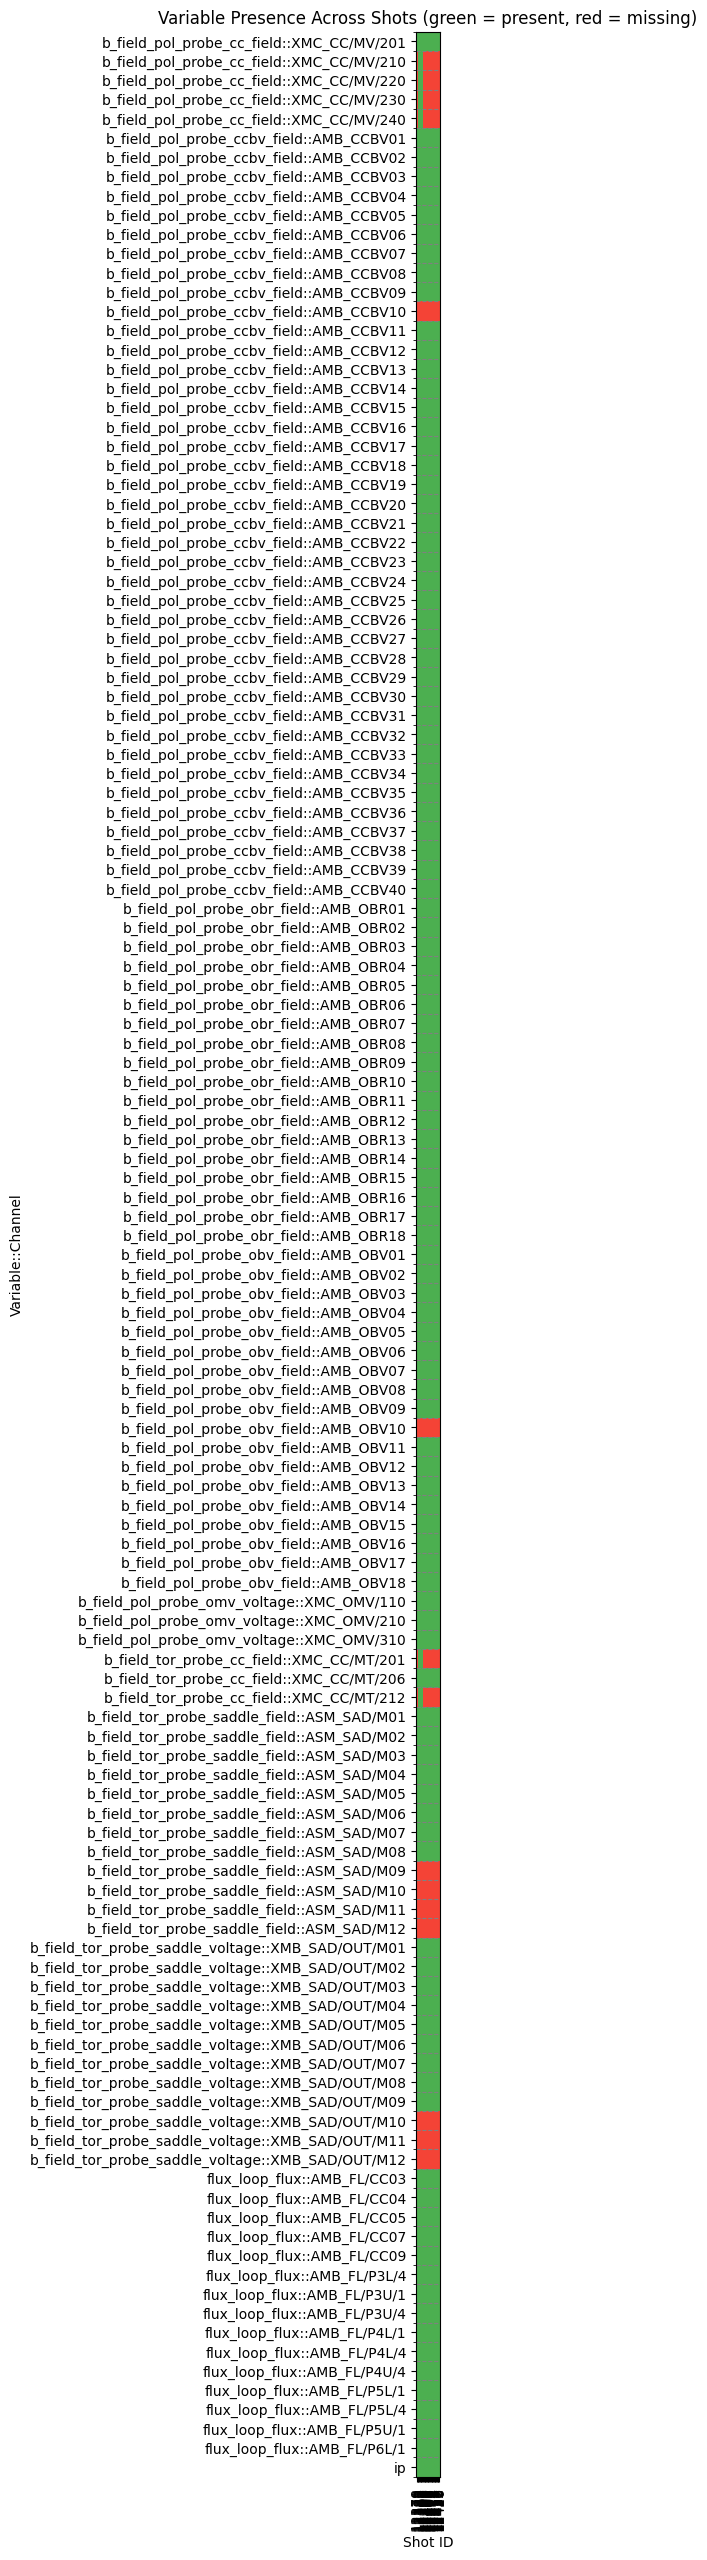

In [25]:
plot_variable_presence(1-nan_proportion_per_shot, plot=True, register=False)

In [31]:
def check_variable_presence_all(path: str, group: str = group, nan_threshold: float = 0.2, shot_threshold=0.99, var_threshold: float = 0.8) -> list:
    """
    Select the good shots and variables::channels to avoid the presence of too many NaNs in the dataset.

    Parameters
    path: str
        Path to the CSV file containing variable presence data.

    Returns
    list(
        good_shots: list of shot IDs that are present in enough variables.
        bad_shots: list of shot IDs that are missing too many variables.
        good_vars: list of variable::channel names that are present in enough shots.
        bad_vars: list of variable::channel names that are missing too many shots.)
    """
    # Load the variable presence DataFrame
    path = pathlib.Path().absolute().parent.parent / path
    df = pd.read_csv(path, index_col=0)
    df = df.fillna(False).infer_objects(copy=False)

    # In the begining, create the mask base on the nan_threshold
    mask = df < nan_threshold

    # First delete the variables::channels for which at least 50% of the content is True. And store them in an array.
    bad_vars = df.index[mask.sum(axis=1) < (len(df.columns) * var_threshold)].tolist()
    df_cleand_1 = df.drop(index=bad_vars)
    plot_variable_presence(1-df_cleand_1, plot=True, register=False)

    # Then delete the shots for which all variables are False. And store them in an array.
    bad_shots = df_cleand_1.columns[df_cleand_1.sum(axis=0) < (len(df_cleand_1.index) * shot_threshold)].tolist()
    df_cleand_2 = df_cleand_1.drop(columns=bad_shots)
    plot_variable_presence(1-df_cleand_2, plot=True, register=False)


    return [
        df_cleand_2.columns.tolist(),   # Good shots
        bad_shots,                      # Bad  shots
        df_cleand_2.index.tolist(),     # Good variables::channels
        bad_vars                        # Bad  variables::channels
        ]

/tmp/ipykernel_1527837/444699559.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = variable_presence_all.fillna(False).infer_objects(copy=False)


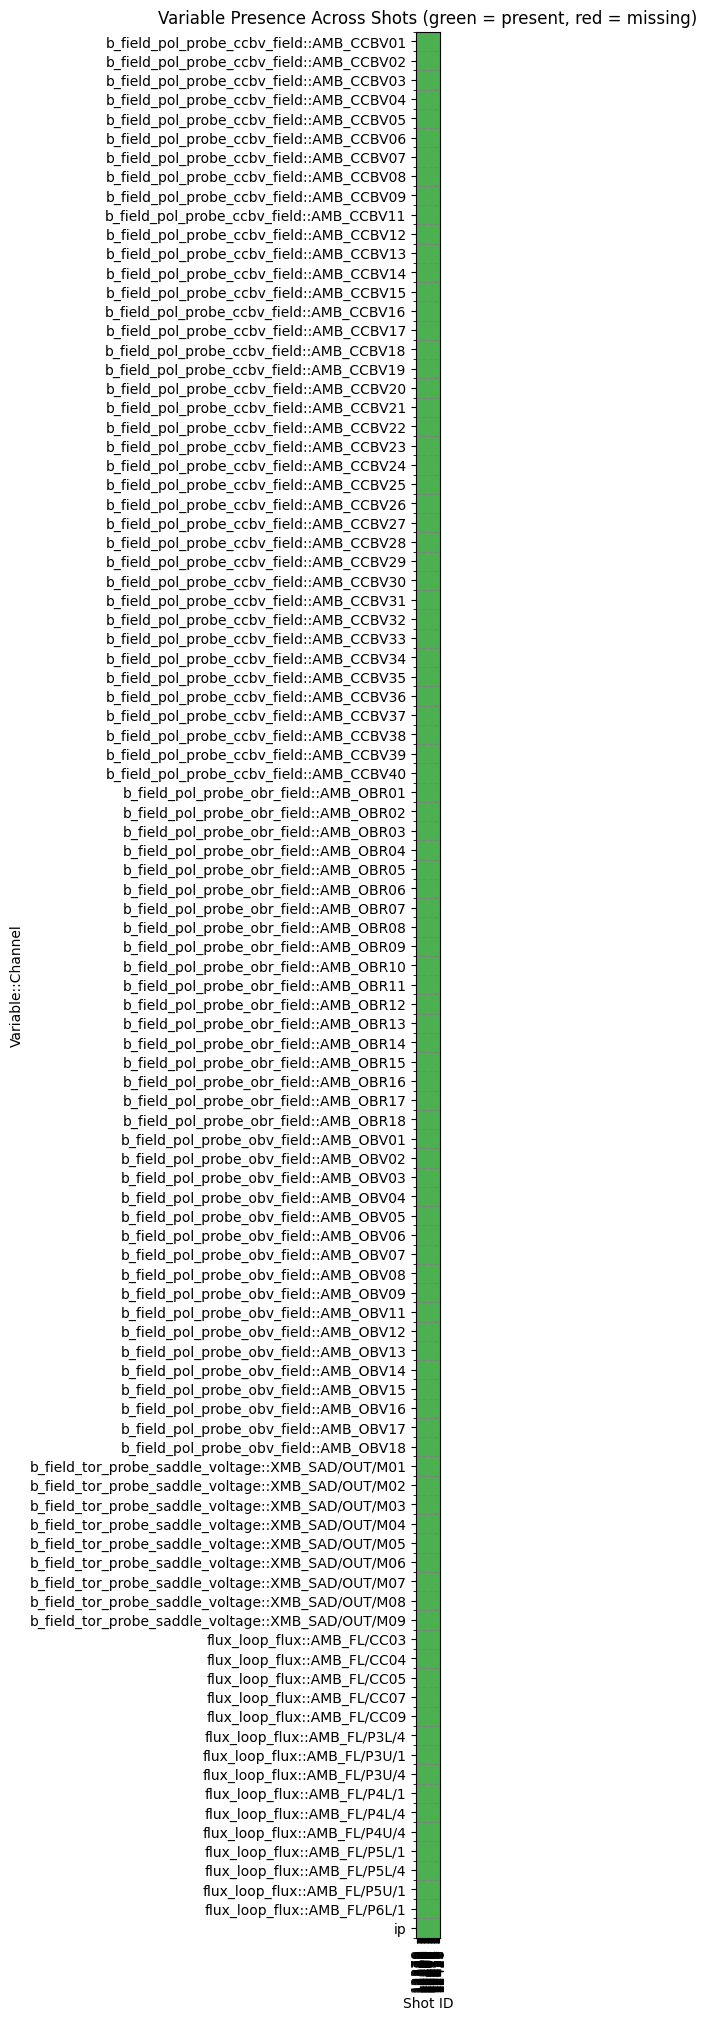

/tmp/ipykernel_1527837/444699559.py:38: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(~int_matrix, aspect='auto', cmap=cmap, interpolation='none')
/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/.venv/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/.venv/lib/python3.11/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/.venv/lib/python3.11/site-packages/matplotlib/patches.py:796: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/home/ITER/brussel/Documents/ITER-magnetics-diagnostic-analysis/.venv

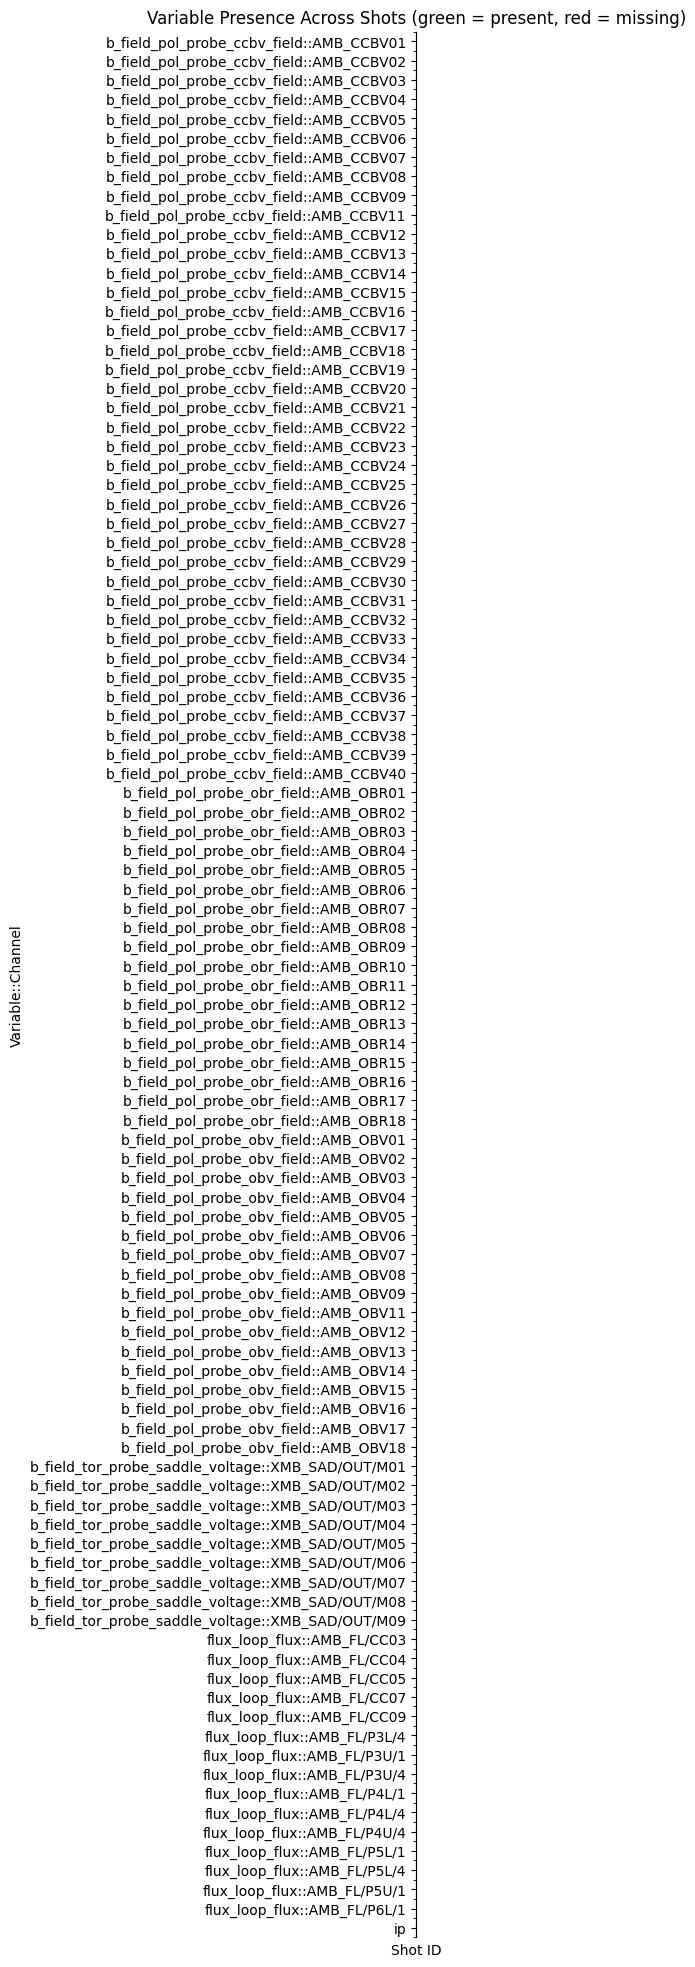

Number of bad variable::channel IDs: 28
Bad variable::channel IDs: ['b_field_pol_probe_cc_field::XMC_CC/MV/201', 'b_field_pol_probe_cc_field::XMC_CC/MV/210', 'b_field_pol_probe_cc_field::XMC_CC/MV/220', 'b_field_pol_probe_cc_field::XMC_CC/MV/230', 'b_field_pol_probe_cc_field::XMC_CC/MV/240', 'b_field_pol_probe_ccbv_field::AMB_CCBV10', 'b_field_pol_probe_obv_field::AMB_OBV10', 'b_field_pol_probe_omv_voltage::XMC_OMV/110', 'b_field_pol_probe_omv_voltage::XMC_OMV/210', 'b_field_pol_probe_omv_voltage::XMC_OMV/310', 'b_field_tor_probe_cc_field::XMC_CC/MT/201', 'b_field_tor_probe_cc_field::XMC_CC/MT/206', 'b_field_tor_probe_cc_field::XMC_CC/MT/212', 'b_field_tor_probe_saddle_field::ASM_SAD/M01', 'b_field_tor_probe_saddle_field::ASM_SAD/M02', 'b_field_tor_probe_saddle_field::ASM_SAD/M03', 'b_field_tor_probe_saddle_field::ASM_SAD/M04', 'b_field_tor_probe_saddle_field::ASM_SAD/M05', 'b_field_tor_probe_saddle_field::ASM_SAD/M06', 'b_field_tor_probe_saddle_field::ASM_SAD/M07', 'b_field_tor_probe_

In [32]:
good_shot_ids, bad_shot_ids, good_vars_ids, bad_vars_ids = check_variable_presence_all(
    path=f"notebooks/result_files/nan_stats_{group}/nan_stats_by_shot_{suffix}.csv",
    group=group,
    shot_threshold=0.99,
    var_threshold=0.8,
)

print(f"Number of bad variable::channel IDs: {len(bad_vars_ids)}")
print("Bad variable::channel IDs:", bad_vars_ids[:25])

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:25])

In [ ]:
data = {
    "metadata": {
        "description": "We selected shots and variables based on Nan presence or not.",
        "good_shot_ids": "List of shot IDs with at least one float value",
        "bad_shot_ids": "List of shot IDs with no values at all or with all NaN values", 
        "good_vars_ids": "List of variable IDs recommended for analysis",
        "bad_vars_ids": "List of variable IDs to avoid or filter out"
    },
    "good_shot_ids": good_shot_ids,
    "bad_shot_ids": bad_shot_ids,
    "good_vars_ids": good_vars_ids,
    "bad_vars_ids": bad_vars_ids,
}

path = pathlib.Path().absolute().parent.parent / f"notebooks/result_files/all_shots_{group}"
file_name = path / f"result_lists_{group}.json"
with open(file_name, "w") as f:
    json.dump(data, f, indent=4)

In [ ]:
def compute_nan_proportions_shots(data: xr.Dataset, sorted: bool = False, ascend_sorting: bool = False) -> pd.DataFrame:
    """
    Compute the proportion of NaN values for each variable in the dataset, grouped by shot.

    Parameters
    data (xr.Dataset): The input dataset containing variables to analyze.
    sorted (bool): If True, sort the results by NaN proportion in descending order.
    ascend_sorting (bool): If True, sort in ascending order; if False, sort in descending order.

    Returns
    pd.DataFrame: A DataFrame containing the variable names, channel names (if applicable), and their NaN proportions per shot.
    """

    shot_index = data['shot_index'].values
    unique_shots = np.unique(shot_index)

    results = []

    for var_name, da in data.data_vars.items():
        dims = da.dims

        if 'time' not in dims:
            continue

        if len(dims) == 1:
            # 1D variable (time)
            row = {'variable': var_name, 'channel': None}
            for shot in unique_shots:
                shot_mask = (shot_index == shot)
                total = shot_mask.sum()
                n_nan = da.isnull().values[shot_mask].sum()
                row[f'shot_{shot}'] = 100 * n_nan / total if total > 0 else np.nan
            results.append(row)

        elif len(dims) == 2:
            # 2D variable (time, channel)
            _, channel_dim = dims
            for i, channel_val in enumerate(data[channel_dim].values):
                row = {'variable': var_name, 'channel': str(channel_val)}
                series = da.isel({channel_dim: i})
                for shot in unique_shots:
                    shot_mask = (shot_index == shot)
                    total = shot_mask.sum()
                    n_nan = series.isnull().values[shot_mask].sum()
                    row[f'shot_{shot}'] = 100 * n_nan / total if total > 0 else np.nan
                results.append(row)

    df_nan_by_shot = pd.DataFrame(results)

    if sorted:
        # Find the maximum NaN proportion across all shots for each variable/channel
        max_nan_cols = [col for col in df_nan_by_shot.columns if col.startswith('shot_')]
        df_nan_by_shot['max_nan_ratio'] = df_nan_by_shot[max_nan_cols].max(axis=1)
        df_nan_by_shot = df_nan_by_shot.sort_values(by='max_nan_ratio', ascending=ascend_sorting).reset_index(drop=True)
    
    return df_nan_by_shot